In [102]:
#imports
import tensorflow as tf
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import copy


# NOTE:
This document assumes familiarity with multivariate calculus and matrix calculus. My goal was not to teach these concepts, but to show how the multivariate chain rule naturally leads to a modular, scalable implementation of backpropagation in neural networks.




# Mathamatical motivation <br>
In ML, we represent the model as a layer of multivarite functions, labeled $L_n$. <br> 
The model is defeined as a mathamatical compositon of all of these layers $M = L_n(L_{n-1}(L_{n-2}(...L_1)))$
Each layer $L_n$ is a function with respect to its paramaters $p$, and input, which is the previous layer.
Then, we have the cost function $C$. This is a scalar function whose exact behavior depends on the ML task, but has key properties: <br>
1. **Can be written as a function of $M$**
2. **Gets bigger as the output's devation from the expected output increases**
3. **is differentiable** <br>
In gradient descent, the idea is to find $\nabla{C}$ with respect to the model paramaters, subpract the corresponding paramaters, and repeat. <br>
Idea is to move in the direction of steepest descent. <br>


## Section II: the algoritm
The modular idea comes from a concept in math called the **multivariate chain rule** <br>
<br> Given a scalar $f=g(\mathbf{u}(\vec{I}))$, the gradient $\nabla{f}$ with respect to $\vec{I}$ is:
$$\nabla{f} = \mathbf{J}_u^\top \cdot \nabla{g}$$
Where $\mathbf{J}_u$ is the jacobian of the multivariate function $\mathbf{u}$. <br>
Note that here, we are computing matrix multiplcation between the jacobian matrix $\mathbf{J}_u$ and the multivariate function $\mathbf{u}$ <br>
Using this rule, we can write an algorithm to find the gradient wtih respect to the outer function's gradient: <br>
for each layer $L_n$, we can write $C = A_n(\mathbf{L_n}(\vec{p}))$, where $\vec{p}$ are the paramaters of the layer, and $A$ is the composition of all the other layers that im too lazy to write <br>
We can use the rule baove to find the gradient with respect to the paramaters and easily perform gradient descent. <br>

Finally, we can find the gradient with respect to the inputs of the layer by writing $C = A_n(\mathbf{L_n}(\mathbf{L_{n-1}}))$ and using the multivarite chain rule.<br>

We then move on to layer $L_{n-1}$. This time, we realize that the outer function $A_{n-1}$ is equal to $A_n(\mathbf{L_n})$. <br>
Since we already have the gradient of the right hand side, this saves us a lot of computation. <br>

## Section III: Gradient Descent

As such, we can impliment gradient descent as follows:
1. first, we start at the topmost layer, n = N, and find $\nabla{C}$ with respect to its input. 
2. Complete the algorithm described above, and keep track of the gradient wtih respect to $L_n$'s input
3. Move to the lower layer, n = n-1, and complete step 2 with the newly found gradient. Stop once we reach n = 0

# Code implementation
I represented each layer $L_n$ as a class with 2 key methods:
1. **backprop**: computes the algorithm described in section II, given the gradient of the outer function
2. **feedfoward**: computes the output of the layer given its input
Some layers, like Dense, have inputs allowing for saved paramaters to be entered.

Then, I implimented a wrapper class called ANN to encapsualte a typical artifical nerual network. It also has 2 key methods:
1. **gradDescent**: computes gradient descent as described in section III, given input-output pairs. Uses a MSE cost function
2. **compute**: given an input, computes the output of the model by chaining the model's layers together

In [150]:
class Dense:
    def __init__(self,inputAmnt: int, outputAmnt: int,w = None,b = None):
        if not np.all(w):
            self.w = 10*np.random.random_sample(size=(outputAmnt,inputAmnt))
        else:
            self.w = w
        self.dw = np.zeros_like(self.w)
        if not np.all(b):
            self.b =  np.random.random_sample(size=(outputAmnt,1))
        else:
            self.b = b
        self.db = np.zeros_like(self.b)
        self.iterator = 0
        self.a = None
    def ein(self,x,y):
        return np.einsum("i,j -> ij",np.transpose(x)[0],np.transpose(y)[0])
    def feedfoward(self,a_0):
        self.a = a_0
        return  self.w @ a_0 + self.b

    def backprop(self, alpha,dz,batch_size):
        self.iterator+=1
        self.db += alpha * dz
        self.dw += alpha * self.ein(dz,self.a)
        if(self.iterator == batch_size):
            self.w -= self.dw
            self.dw -= self.dw
            self.b -= self.db
            self.db -= self.db
            self.iterator = 0
        return np.transpose(self.w) @ dz
class softmax:
    def __init__(self):
        self.a_0 = None
    def feedfoward(self,a_0):
        self.a_0 = a_0
        return a_0/(np.sum(a_0)+1e-10)
    
    def backprop(self,alpha,dz,batch_size):
        summation = np.sum(self.a_0) + 1e-10
        return dz * (1/summation-self.a_0/(summation**2))
class act:
    def __init__(self):
        self.a_0 = None
        self.mask = None
        self.mask1 = None
    def feedfoward(self,a_0):
        self.a_0 = a_0
        self.mask = (a_0 >= 0)
        self.mask1 = (a_0 < 0)
        a = np.zeros_like(a_0)
        a[self.mask] = self.a_0[self.mask]+1
        a[self.mask1] = np.exp(self.a_0[self.mask1])
        return a
    
    def backprop(self,alpha,dz,batch_size):
        a = np.zeros_like(self.a_0)
        a[self.mask] = 1
        a[self.mask1] = np.exp(self.a_0[self.mask1])
        return dz * a
#incomplete
class ConvlutionLayer:
    def __init__(self,length,kernal=None):
        if(not kernal):
            self.kernal = np.random.random_sample(size=(length))
        else:
            self.kernal = kernal
        

class ANN:
    def __init__(self,*layers):
        self.layers = list(layers)
    def compute(self,inp):
        output = inp
        for layer in self.layers:
            output = layer.feedfoward(output)
        return output
    def gradDescent(self,inputs,outputs,lr,epochs,returnAcc = False,BATCH_SIZE=1):
        acc = []
        for i in range(epochs):
            iterator = 0
            for (input,output) in zip(inputs,outputs):
                dz = 2*(self.compute(input)-output)
                for layer in self.layers[::-1]:
                    dz = layer.backprop(lr,dz,BATCH_SIZE)
            if(returnAcc):
                acc.append(self.testAcc2(inputs,outputs))
        return acc
    def testAccuracy(self,inputs,outputs):
        error = 0
        for(input, output) in zip(inputs,outputs):
            if(np.argmax(self.compute(input)) != output):
                error +=1
        return 1-error/len(inputs)
    def testAcc2(self,inputs,outputs):
        error = 0
        for(input, output) in zip(inputs,outputs):
            if(np.argmax(self.compute(input)) != np.argmax(output)):
                error +=1
        return 1-error/len(inputs)

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1,1) / 255  # input for training
x_test = x_test.reshape(x_test.shape[0], -1,1) / 255  # input for testing
y_train = y_train.reshape(60_000,1)
def encode(input):
    z = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    z[0][input] = 1
    return np.transpose(z)
output_test = np.apply_along_axis(encode,1,y_train)


In [4]:
params = np.load("params.npz")

Model with 15 hidden layers, 1 layer hidden

In [5]:
model = ANN(Dense(784,15,params["w0"],params["b0"]),act(),softmax(),Dense(15,10,params["w1"],params["b1"]),act(),softmax()) # saved model

to save new model for 15 neruon hidden layer (if found)

In [180]:
np.savez("params.npz",w0=model.layers[0].w,b0=model.layers[0].b,w1=model.layers[3].w,b1=model.layers[3].b) 

train accuracy

In [92]:
model.testAcc2(x_train,output_test)

0.9473833333333334

train accuracy

In [114]:
model.testAccuracy(x_test,y_test)

0.9348

train og model

In [78]:
def MSE(intput, outtput, model):
    """
    Takes in a input (vector arr) output (vector arr) and model to output a cost (scalar) using MSE
    """
    z = 0
    for (input, output) in zip(intput, outtput):
       loss = model.compute(input)-output
       z += np.sum(loss*loss)
    z /= len(input)
    return z 

In [185]:
y = model.gradDescent(x_train,output_test,lr=5,epochs=10,BATCH_SIZE=10,returnAcc=True)

In [11]:
model2 = ANN(Dense(784,20),act(),softmax(),Dense(20,10),act(),softmax())

In [115]:
np.savez("params2.npz",w0=model2.layers[0].w,b0=model2.layers[0].b,w1=model2.layers[3].w,b1=model2.layers[3].b) 

In [108]:
model2.testAcc2(x_train,output_test)

0.9500333333333333

In [107]:
model2.testAccuracy(x_test,y_test)

0.9326

In [95]:
MSE(x_train,output_test,model)

6.481664046966511

In [106]:
MSE(x_train,output_test,model2)

5.920188351163529

In [111]:
z = model2.gradDescent(x_train,output_test,lr=3,epochs=15,returnAcc=True)

In [112]:
print(z)

[0.9500333333333333, 0.95005, 0.9500333333333333, 0.95005, 0.9500833333333334, 0.9501666666666667, 0.9502, 0.9502333333333334, 0.9502333333333334, 0.9502666666666667, 0.9503, 0.9502666666666667, 0.95035, 0.9504, 0.9504333333333334]


In [151]:
model3 = ANN(Dense(784,128),act(),softmax(),Dense(128,10),act(),softmax())

In [189]:
b = model3.gradDescent(x_train,output_test,lr=5,epochs=15,returnAcc=True)

In [187]:
np.savez("params3.npz",w0=model3.layers[0].w,b0=model3.layers[0].b,w1=model3.layers[3].w,b1=model3.layers[3].b) 

In [190]:
print(b)

[0.9036333333333333, 0.9041, 0.90445, 0.90485, 0.90535, 0.90575, 0.9061666666666667, 0.9064, 0.9070666666666667, 0.9073333333333333, 0.9077500000000001, 0.9080666666666667, 0.9083, 0.9087833333333333, 0.9091166666666667]


In [188]:
model3.testAcc2(x_train,output_test)

0.8983166666666667

epoch vs time graph

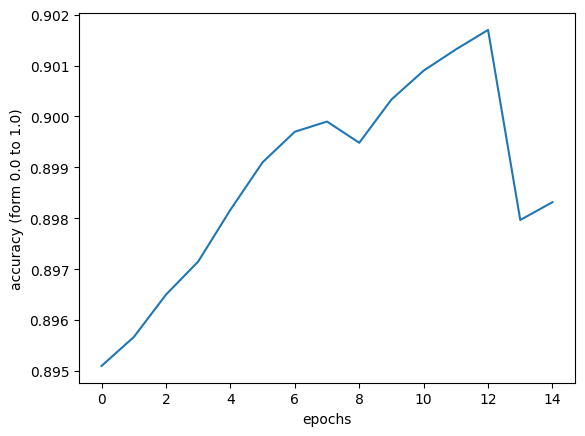

In [186]:
plt.plot(b)
plt.ylabel("accuracy (form 0.0 to 1.0)")
plt.xlabel("epochs")
plt.show()

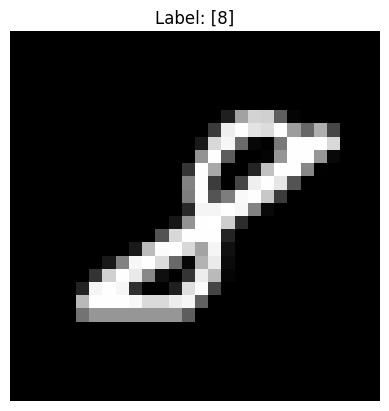

ai prediction 8


In [109]:
imageIndex = 1009
x = x_train[imageIndex].reshape(28,28)
plt.imshow(x,cmap='gray')
plt.title(f"Label: {y_train[imageIndex]}")
plt.axis('off')
plt.show()
print(f"ai prediction {np.argmax(model.compute(x_train[imageIndex]))}")